<img src='../img/joint_school_banner_2.png' alt='joint school banner' align='right' width='100%'></img>

<br>

# Copernicus Sentinel-5P TROPOMI - Sulfur Dioxide - Level 2

Sentinel-5P is a precursor satetllite mission of Sentinel-5. It aims to provide data continuity between the retirement of the Envisat satellite and NASA's Aura mission and the launch of Sentinel-5. The Copernicus Sentinel-5P mission is being used to closely monitor the changes in air quality and was launched in October 2017.

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `Nitrogen dioxide`
* `Sulfur dioxide`
* `Formaldehyde`
* `Aerosol`
* `Carbon monoxide`
* `Methane`
* `Clouds`

The subsequent example introduces you to Sentinel-5P data in general and the total column of sulfur dioxide sensed by Sentinel-5P TROPOMI . Sulfur dioxide is a good trace gas in order to monitor and track air pollution. This notebook shows elevated levels of sulfur dioxide caused by the Hunga Tonga volcanic eruption on 15 January 2022.

### Basic Facts

> **Spatial resolution**: `Up to 5.5* km x 3.5 km` (5.5 km in the satellite flight direction and 3.5 km in the perpendicular direction at nadir) <br>
> **Spatial coverage**: `Global` <br>
> **Revisit time**:  `less than one day` <br>
> **Data availability**: `since April 2018`


### How to access the data

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home). You can login with the following credentials:
* **Username**: `s5pguest`
* **Password**: `s5pguest`

### Module outline
* [1 - Load and browse Sentinel-5P TROPOMI Sulfur Dioxide Level 2 data](#load_s5p)
* [2 - Visualize Sentinel-5P TROPOMI Sulfur Dioxide Level 2 data](#plotting_s5p)

<hr>

#### Load required libraries

In [1]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id="load_s5p"></a>Load and browse Sentinel-5P TROPOMI Sulfur Dioxide Level 2 data

A Sentinel-5P TROPOMI Sulfur Dioxide Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have, among others, the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load multiple `netCDF` files at once with the `open_mfdataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group
- `concat_dim='scanline'`: multiple files will be concatenated based on the scanline dimension
- `combine=nested`: combine n-dimensional grids into one along each dimension of the grid

Let us load several Sentinel-5P TROPOMI data files as `xarray.Dataset` from 15 January 2022 and inspect the data structure:

In [4]:
s5p = xr.open_mfdataset('../../eodata/training_school/sentinel5p/so2/2022/01/15/*', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p

<xarray.Dataset>
Dimensions:                                        (scanline: 8345, ground_pixel: 450, time: 1, corner: 4, layer: 34)
Coordinates:
  * scanline                                       (scanline) float64 0.0 ......
  * ground_pixel                                   (ground_pixel) float64 0.0...
  * time                                           (time) datetime64[ns] 2022...
  * corner                                         (corner) float64 0.0 ... 3.0
  * layer                                          (layer) int32 0 1 2 ... 32 33
Data variables:
    latitude                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>
    longitude                                      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>
    delta_time                                     (time, scanline, ground_pixel) datetime64[ns] dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>
    time_utc                                       (time, scanline) object dask.array<chunksize=(1, 4173), meta=np.ndarray>
    qa_value                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 450), meta=np.ndarray>

You see that the loaded data object contains multiple dimensions and data variables, among others:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `layer`


* **Data variables**:
  * `latitude`: geocoordinates for the latitude
  * `longitude`: geocoordinates for the longitude
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `qa_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `sulfurdioxide_total_vertical_column`: Vertically integrated SO<sub>2</sub> column density
  * `sulfurdioxide_total_vertical_column_precision`: Standard error of the vertically integrated SO<sub>2</sub> column

Sentinel-5P Offline data downloaded from the Sentinel-5P Pre-Operations Data Hub consist of the full swath and orbit. For easier data handling. it is often better to create a subset of the region of interest. The region of interest for the Hunga Tonga eruption is on the southern hemisphere east of Australia's east coast. Let us set the longitude boundaries to `[130, 180]` and the latitude boundaries to `[0, -50]`, respectively.

In [6]:
lonmin=130
lonmax=180
latmin=-50
latmax=0

The xarray function `where()` allows you to subset a xarray Dataset based on the datasets coordinates or variables. Based on the two variables `latitude` and `longitude`, you can subset the data. The keyword argument `drop=True` removes all pixels that are outside of the region of interest. This operations leads to a decrease of the `scanline` coordinate from 8345 data points to 2273 data points.

In [7]:
s5p_subset = s5p.where((s5p.latitude > latmin) & (s5p.latitude < latmax) & (s5p.longitude > lonmin) & (s5p.longitude < lonmax), drop=True)
s5p_subset

<xarray.Dataset>
Dimensions:                                        (time: 1, scanline: 2277, ground_pixel: 450, corner: 4, layer: 34)
Coordinates:
  * scanline                                       (scanline) float64 1.462e+...
  * ground_pixel                                   (ground_pixel) float64 0.0...
  * time                                           (time) datetime64[ns] 2022...
  * corner                                         (corner) float64 0.0 ... 3.0
  * layer                                          (layer) int32 0 1 2 ... 32 33
Data variables:
    latitude                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    longitude                                      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    delta_time                                     (time, scanline, ground_pixel) datetime64[ns] dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    time_utc                                       (time, scanline, ground_pixel) object dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    qa_value                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>

Above, you see that longitude and latitude information are separated as data variables and not assigned as coordinates. In a next step,  we assign the variables as coordinates, with the xarray function `assign_coords()`. This will be helpful later when you want to visualise the data on a latitude-longitude grid.

In [8]:
s5p_subset = s5p_subset.assign_coords(longitude = s5p_subset.longitude, latitude=s5p_subset.latitude)
s5p_subset

<xarray.Dataset>
Dimensions:                                        (time: 1, scanline: 2277, ground_pixel: 450, corner: 4, layer: 34)
Coordinates:
    latitude                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    longitude                                      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
  * scanline                                       (scanline) float64 1.462e+...
  * ground_pixel                                   (ground_pixel) float64 0.0...
  * time                                           (time) datetime64[ns] 2022...
  * corner                                         (corner) float64 0.0 ... 3.0
  * layer                                          (layer) int32 0 1 2 ... 32 33
Data variables:
    delta_time                                     (time, scanline, ground_pixel) datetime64[ns] dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    time_utc                                       (time, scanline, ground_pixel) object dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    qa_value                                       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    sulfurdioxide_total_vertical_column_precision  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>

Now, you can select one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `sulfurdioxide_total_vertical_column` is the atmosphere mole content of sulfur dioxide, has the unit `mol per m-2`, and has three dimensions, `time`, `scanline` and `ground_pixel` respectively.

In [9]:
s5p_so2 = s5p_subset['sulfurdioxide_total_vertical_column']
s5p_so2

<xarray.DataArray 'sulfurdioxide_total_vertical_column' (time: 1, scanline: 2277, ground_pixel: 450)>
dask.array<where, shape=(1, 2277, 450), dtype=float32, chunksize=(1, 1181, 450), chunktype=numpy.ndarray>
Coordinates:
    latitude      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    longitude     (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
  * scanline      (scanline) float64 1.462e+03 1.463e+03 ... 2.55e+03 2.551e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2022-01-15
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             total vertical col...
    coordinates:                                           /PRODUCT/longitude...
    multiplication_factor_to_convert_to_DU:                2241.15
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

In a next step, you can filter out all pixels with a negative SO2 value. You can do this with the xarray function `where()`.

In [9]:
s5p_so2 = s5p_so2.where(s5p_so2 > 0, 0)
s5p_so2

<xarray.DataArray 'sulfurdioxide_total_vertical_column' (time: 1, scanline: 2277, ground_pixel: 450)>
dask.array<where, shape=(1, 2277, 450), dtype=float32, chunksize=(1, 1181, 450), chunktype=numpy.ndarray>
Coordinates:
    latitude      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    longitude     (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
  * scanline      (scanline) float64 1.462e+03 1.463e+03 ... 2.55e+03 2.551e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2022-01-15
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             total vertical col...
    coordinates:                                           /PRODUCT/longitude...
    multiplication_factor_to_convert_to_DU:                2241.15
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

The attributes of the `xarray.DataArray` above hold the entry `multiplication_factor_to_convert_to_DU`, which is a conversion factor that has to be applied to convert the data from `mol per m`<sup>`2`</sup> to `Dobson Unit`.


In [10]:
s5p_so2_du = s5p_so2 * s5p_so2.multiplication_factor_to_convert_to_DU
s5p_so2_du

<xarray.DataArray 'sulfurdioxide_total_vertical_column' (time: 1, scanline: 2277, ground_pixel: 450)>
dask.array<mul, shape=(1, 2277, 450), dtype=float32, chunksize=(1, 1181, 450), chunktype=numpy.ndarray>
Coordinates:
    latitude      (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
    longitude     (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 1096, 450), meta=np.ndarray>
  * scanline      (scanline) float64 1.462e+03 1.463e+03 ... 2.55e+03 2.551e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 447.0 448.0 449.0
  * time          (time) datetime64[ns] 2022-01-15

## <a id="plotting_s5p"></a>Visualize Sentinel-5P TROPOMI Sulfur Dioxide Level 2 data

Now, let us visualize the total colum of sulfur dioxide in Dobson Unit recorded by the Sentinel-5P TROPOMI sensor on 15 January 2022. You can visualize data arrays with matplotlib's `pcolor()` function. In combination with the library [Cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

First, let us create a custom color map with colors from Yellow - Orange - Brown and let us call the color map `my_cmap`.

In [11]:
cm_values = np.linspace(0, 1, 16536)

# use the Yellow Orange Brown color map as reference
alpha_cm = plt.cm.YlOrBr(cm_values)

# change alpha value to follow a square low
alpha_cm[:, -1] = np.sqrt(cm_values)

# build new color map
my_cmap = colors.ListedColormap(alpha_cm)

The last step is to visualize the data with matplotlib's function `pcolor()`.

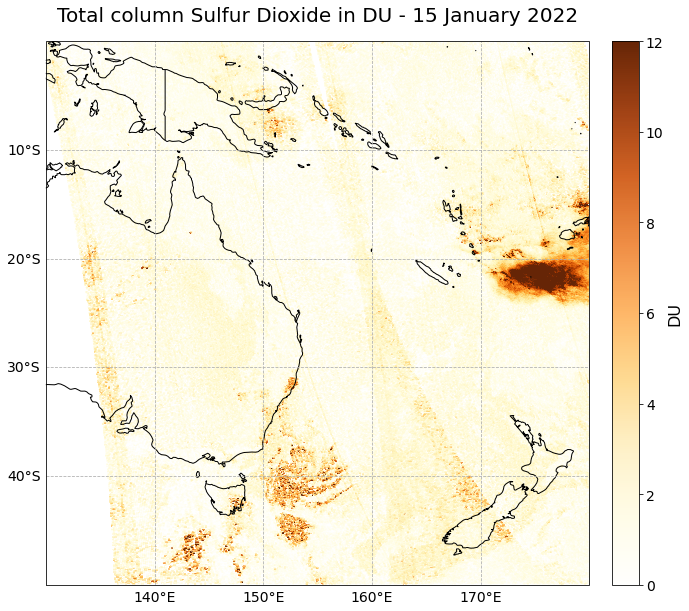

In [12]:
# Initiate the matplotlib plot and an axes object
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define latitude and longitude coordinate information
lat = s5p_so2_du.latitude[0,:,:].data
lon = s5p_so2_du.longitude[0,:,:].data

# Set geographic extent based on bounding box information defined and add geographic features, such as Borders and coastlines
ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

# Format grid lines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Plot the data with the function `pcolor()` in PlateCarree projection
img = plt.pcolor(lon, 
                 lat, 
                 s5p_so2_du[0,:,:], 
                 cmap=plt.get_cmap(my_cmap), 
                 transform=ccrs.PlateCarree(),
                 vmin=0,
                 vmax=12,
                 shading='auto')

# Format colorbar
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
cbar.set_label('DU', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Set plot title
ax.set_title('Total column Sulfur Dioxide in DU - 15 January 2022', fontsize=20, pad=20.0)

plt.show()

<br>

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>